# Intro

In [1]:
# The goal is to implement and test the method described in the first paper:
# Learning Representations and Generative Models for 3D Point Clouds
# https://arxiv.org/abs/1707.02392
# https://arxiv.org/pdf/1707.02392.pdf
# by Panos Achlioptas, Olga Diamanti, Ioannis Mitliagkas, and Leonidas Guibas
# https://github.com/optas/latent_3d_points

In [2]:
# Data Set
# We provide ~57K point-clouds, each sampled from a mesh model of ShapeNetCore with (area) uniform sampling.
# The point-clouds will be stored in latent_3d_points/data/shape_net_core_uniform_samples_2048
# Use the function snc_category_to_synth_id, defined in src/in_out/, to map a class name such as "chair" to its synthetic_id: "03001627". Point-clouds of models of the same class are stored under a commonly named folder.

import os

path = 'latent_3d_points/data/shape_net_core_uniform_samples_2048/03001627'
files = os.listdir(path)
print(len(files))
print(files[:10])

6778
['787a4db5b3452fc357a847db7547c1f3.ply', '23b0da45f23e5fb4f4b6538438a0b930.ply', 'fc6129a9310ba34c645311c54e2f9bdc.ply', '987770212e08392d2c528d33bca1ac2.ply', '9bdb034f30c404edba1028cd22cb8779.ply', 'f2dae367e56200a7d9b53420a5458c53.ply', 'c94f7f5ec96e10994231039830c7e1d1.ply', '9fae85a69532d03fda686a7d8e3d0692.ply', 'bd6fcae754203396e34dfbaf829eddf7.ply', '8d18fba375d0545edbbc9440457e303e.ply']


In [3]:
# Files are stored in .ply format. We provide a function to read them in src/in_out/ply.py

# In out and general_utils

In [4]:
import numpy as np
import os
import matplotlib.pylab  as plt
import warnings
import re
from ipywidgets import interact
import ipywidgets as widgets
from multiprocessing import Pool
from plyfile import PlyData
from tqdm.notebook import tqdm


In [5]:
snc_synth_id_to_category = {
    '02691156': 'airplane',  '02773838': 'bag',        '02801938': 'basket',
    '02808440': 'bathtub',   '02818832': 'bed',        '02828884': 'bench',
    '02834778': 'bicycle',   '02843684': 'birdhouse',  '02871439': 'bookshelf',
    '02876657': 'bottle',    '02880940': 'bowl',       '02924116': 'bus',
    '02933112': 'cabinet',   '02747177': 'can',        '02942699': 'camera',
    '02954340': 'cap',       '02958343': 'car',        '03001627': 'chair',
    '03046257': 'clock',     '03207941': 'dishwasher', '03211117': 'monitor',
    '04379243': 'table',     '04401088': 'telephone',  '02946921': 'tin_can',
    '04460130': 'tower',     '04468005': 'train',      '03085013': 'keyboard',
    '03261776': 'earphone',  '03325088': 'faucet',     '03337140': 'file',
    '03467517': 'guitar',    '03513137': 'helmet',     '03593526': 'jar',
    '03624134': 'knife',     '03636649': 'lamp',       '03642806': 'laptop',
    '03691459': 'speaker',   '03710193': 'mailbox',    '03759954': 'microphone',
    '03761084': 'microwave', '03790512': 'motorcycle', '03797390': 'mug',
    '03928116': 'piano',     '03938244': 'pillow',     '03948459': 'pistol',
    '03991062': 'pot',       '04004475': 'printer',    '04074963': 'remote_control',
    '04090263': 'rifle',     '04099429': 'rocket',     '04225987': 'skateboard',
    '04256520': 'sofa',      '04330267': 'stove',      '04530566': 'vessel',
    '04554684': 'washer',    '02858304': 'boat',       '02992529': 'cellphone'
}

category_to_snc_synth_id = {v: k for k, v in snc_synth_id_to_category.items()}
categories = sorted(list(category_to_snc_synth_id.keys()))

In [6]:
snc_synth_id = '03001627' # chair
print(snc_synth_id_to_category[snc_synth_id])
path = 'latent_3d_points/data/shape_net_core_uniform_samples_2048/' + snc_synth_id
files = os.listdir(path)
print(len(files))
print(files[:2])

chair
6778
['787a4db5b3452fc357a847db7547c1f3.ply', '23b0da45f23e5fb4f4b6538438a0b930.ply']


In [7]:
def load_ply(file_name, with_faces=False, with_color=False):
    ply_data = PlyData.read(file_name)
    points = ply_data['vertex']
    points = np.vstack([points['x'], points['y'], points['z']]).T
    ret_val = [points]

    if with_faces:
        faces = np.vstack(ply_data['face']['vertex_indices'])
        ret_val.append(faces)

    if with_color:
        r = np.vstack(ply_data['vertex']['red'])
        g = np.vstack(ply_data['vertex']['green'])
        b = np.vstack(ply_data['vertex']['blue'])
        color = np.hstack((r, g, b))
        ret_val.append(color)

    if len(ret_val) == 1:  # Unwrap the list
        ret_val = ret_val[0]

    return ret_val

In [8]:
ret = load_ply(os.path.join(path, files[0]))
print(ret.shape)

(2048, 3)


In [9]:
def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False, marker='.', s=8, alpha=.8, figsize=(5, 5), elev=10, azim=240, axis=None, title=None, *args, **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')        
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])  # Multiply with 0.7 to squeeze free-space.
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig

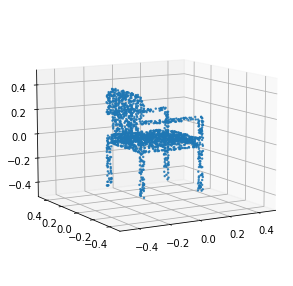

In [10]:
# plot the first point cloud

fig = plot_3d_point_cloud(ret[:, 0], ret[:, 1], ret[:, 2], in_u_sphere=True)

In [11]:
# ipywidgets interact
def plot_point_cloud(category, i, elev, azim):
    snc_synth_id = category_to_snc_synth_id[category]
    path = 'latent_3d_points/data/shape_net_core_uniform_samples_2048/' + snc_synth_id
    files = os.listdir(path)
    ret = load_ply(os.path.join(path, files[i]))
    fig = plot_3d_point_cloud(ret[:, 0], ret[:, 1], ret[:, 2], in_u_sphere=True,
                              title='{}: {}'.format(category, files[i]),
                              figsize=(16, 7), elev=elev, azim=azim)
                        
interact(plot_point_cloud, category=categories, i=widgets.IntSlider(min=0, max=100, step=1, value=0),
            elev=widgets.IntSlider(min=-90, max=90, step=1, value=20),
            azim=widgets.IntSlider(min=-180, max=180, step=1, value=0))

interactive(children=(Dropdown(description='category', options=('airplane', 'bag', 'basket', 'bathtub', 'bed',…

<function __main__.plot_point_cloud(category, i, elev, azim)>

In [14]:
# files_in_subdirs returns a list of all files in the subdirectories of the top_dir directory that match the search_pattern.
# In this case, it returns a list of all .ply files in the subdirectories of the top_dir directory.

# pc_loader is a function that loads a point cloud from a file. It returns the point cloud, the model name, and the synset id.

# load_point_clouds_from_filenames returns a tuple of three numpy arrays.
# The first array contains the point clouds, the second array contains the model names, and the third array contains the synset IDs.

# load_all_point_clouds_under_folder returns a PointCloudDataSet object.

# The PointCloudDataSet object contains the point clouds, the model names, and the synset IDs.

In [21]:
class PointCloudDataSet(object):
    '''
    See https://github.com/tensorflow/tensorflow/blob/a5d8217c4ed90041bea2616c14a8ddcf11ec8c03/tensorflow/examples/tutorials/mnist/input_data.py
    '''

    def __init__(self, point_clouds, noise=None, labels=None, copy=True, init_shuffle=True):
        '''Construct a DataSet.
        Args:
            init_shuffle, shuffle data before first epoch has been reached.
        Output:
            original_pclouds, labels, (None or Feed) # TODO Rename
        '''

        self.num_examples = point_clouds.shape[0]
        self.n_points = point_clouds.shape[1]

        if labels is not None:
            assert point_clouds.shape[0] == labels.shape[0], ('points.shape: %s labels.shape: %s' % (point_clouds.shape, labels.shape))
            if copy:
                self.labels = labels.copy()
            else:
                self.labels = labels

        else:
            self.labels = np.ones(self.num_examples, dtype=np.int8)

        if noise is not None:
            assert (type(noise) is np.ndarray)
            if copy:
                self.noisy_point_clouds = noise.copy()
            else:
                self.noisy_point_clouds = noise
        else:
            self.noisy_point_clouds = None

        if copy:
            self.point_clouds = point_clouds.copy()
        else:
            self.point_clouds = point_clouds

        self.epochs_completed = 0
        self._index_in_epoch = 0
        if init_shuffle:
            self.shuffle_data()

    def shuffle_data(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        perm = np.arange(self.num_examples)
        np.random.shuffle(perm)
        self.point_clouds = self.point_clouds[perm]
        self.labels = self.labels[perm]
        if self.noisy_point_clouds is not None:
            self.noisy_point_clouds = self.noisy_point_clouds[perm]
        return self

    def next_batch(self, batch_size, seed=None):
        '''Return the next batch_size examples from this data set.
        '''
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self.num_examples:
            self.epochs_completed += 1  # Finished epoch.
            self.shuffle_data(seed)
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
        end = self._index_in_epoch

        if self.noisy_point_clouds is None:
            return self.point_clouds[start:end], self.labels[start:end], None
        else:
            return self.point_clouds[start:end], self.labels[start:end], self.noisy_point_clouds[start:end]

    def full_epoch_data(self, shuffle=True, seed=None):
        '''Returns a copy of the examples of the entire data set (i.e. an epoch's data), shuffled.
        '''
        if shuffle and seed is not None:
            np.random.seed(seed)
        perm = np.arange(self.num_examples)  # Shuffle the data.
        if shuffle:
            np.random.shuffle(perm)
        pc = self.point_clouds[perm]
        lb = self.labels[perm]
        ns = None
        if self.noisy_point_clouds is not None:
            ns = self.noisy_point_clouds[perm]
        return pc, lb, ns

    def merge(self, other_data_set):
        self._index_in_epoch = 0
        self.epochs_completed = 0
        self.point_clouds = np.vstack((self.point_clouds, other_data_set.point_clouds))

        labels_1 = self.labels.reshape([self.num_examples, 1])  # TODO = move to init.
        labels_2 = other_data_set.labels.reshape([other_data_set.num_examples, 1])
        self.labels = np.vstack((labels_1, labels_2))
        self.labels = np.squeeze(self.labels)

        if self.noisy_point_clouds is not None:
            self.noisy_point_clouds = np.vstack((self.noisy_point_clouds, other_data_set.noisy_point_clouds))

        self.num_examples = self.point_clouds.shape[0]

        return self


In [60]:
def files_in_subdirs(top_dir, search_pattern):
    regex = re.compile(search_pattern)
    for path, _, files in os.walk(top_dir):
        for name in files:
            full_name = os.path.join(path, name)
            if regex.search(full_name):
                yield full_name

def pc_loader(f_name):
    ''' loads a point-cloud saved under ShapeNet's "standar" folder scheme: 
    i.e. /syn_id/model_name.ply
    '''
    tokens = f_name.split('/')
    model_id = tokens[-1].split('.')[0]
    synet_id = tokens[-2]
    return load_ply(f_name), model_id, synet_id


def load_point_clouds_from_filenames(file_names, n_threads, loader, verbose=False):
    pc = loader(file_names[0])[0]
    pclouds = np.empty([len(file_names), pc.shape[0], pc.shape[1]], dtype=np.float32)
    model_names = np.empty([len(file_names)], dtype=object)
    class_ids = np.empty([len(file_names)], dtype=object)
    #pool = Pool(n_threads)

    #for i, data in enumerate(pool.imap(loader, file_names)): 
    #    pclouds[i, :, :], model_names[i], class_ids[i] = data

    #pool.close()
    #pool.join()

    for i, f_name in tqdm(enumerate(file_names), total=len(file_names), disable=not verbose):
        pclouds[i, :, :], model_names[i], class_ids[i] = loader(f_name)

    if len(np.unique(model_names)) != len(pclouds):
        warnings.warn('Point clouds with the same model name were loaded.')

    if verbose:
        print('{0} pclouds were loaded. They belong in {1} shape-classes.'.format(len(pclouds), len(np.unique(class_ids))))

    return pclouds, model_names, class_ids

def load_all_point_clouds_under_folder(top_dir, n_threads=20, file_ending='.ply', verbose=False):
    file_names = [f for f in files_in_subdirs(top_dir, file_ending)]
    pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(file_names, n_threads, loader=pc_loader, verbose=verbose)
    return PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids, init_shuffle=False)

In [61]:
# example usage

class_name = 'chair'
syn_id = category_to_snc_synth_id[class_name]
path = path = 'latent_3d_points/data/shape_net_core_uniform_samples_2048/'
top_dir = os.path.join(path, syn_id)

load_all_point_clouds_under_folder(top_dir, file_ending='.ply', verbose=True)

  0%|          | 0/6778 [00:00<?, ?it/s]

6778 pclouds were loaded. They belong in 1 shape-classes.


# Implementation

In [ ]:
# In our implementation we use 5 1-D convolutional layers, each followed by a ReLU (Nair & Hinton, 2010) and a batch-normalization layer (Ioffe & Szegedy, 2015). The output of the last convolutional layer is passed to a feature-wise maximum to produce a k-dimensional vector which is the basis for our latent space.

# let's try this with pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Encoder(nn.Module):
    def __init__(self, latent_size=1024):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.conv3 = nn.Conv1d(64, 64, 1)
        self.conv4 = nn.Conv1d(64, 128, 1)
        self.conv5 = nn.Conv1d(128, latent_size, 1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(latent_size)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
    



In [ ]:

def mlp_architecture_ala_iclr_18(n_pc_points, bneck_size, bneck_post_mlp=False):
    ''' Single class experiments.
    '''
    if n_pc_points != 2048:
        raise ValueError()

    encoder = encoder_with_convs_and_symmetry
    decoder = decoder_with_fc_only

    n_input = [n_pc_points, 3]

    encoder_args = {'n_filters': [64, 128, 128, 256, bneck_size],
                    'filter_sizes': [1],
                    'strides': [1],
                    'b_norm': True,
                    'verbose': True
                    }

    decoder_args = {'layer_sizes': [256, 256, np.prod(n_input)],
                    'b_norm': False,
                    'b_norm_finish': False,
                    'verbose': True
                    }

    if bneck_post_mlp:
        encoder_args['n_filters'].pop()
        decoder_args['layer_sizes'][0] = bneck_size

    return encoder, decoder, encoder_args, decoder_args

In [ ]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(2048, 128)